# Argo Oxygen Gradient Analysis

This notebook to provide code for analysis of oxygen gradients (dO2/dz) in relation to the time response of oxygen optodes, and to what magnitude we might expect the lag correction to change existing profiles. It is also meant to provide context for how many floats and/or profiles are probably "bad" due to this inherent sensor error.

## 1 - Import relevant packages and load Argo oxygen data

The following code grabs the index of Argo profiles that contain dissolved oxygen data, subsets it for profiles more recent than 2016, and then further subsets it to be a random selection of those profiles. The package [argopandas](https://argocanada.github.io/argopandas/released/#) is used to do the heavy lifting.

In [6]:
# numerics, data fetching/handling
import numpy as np
import pandas as pd
import argopandas as argo

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# set up some plotting preferences
sns.set(style='ticks', palette='colorblind')

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

Grab 500 random profiles. Getting the whole dataset would take a long time, but this should be an ok balance of computation time and having enough profiles to get a reasonably representative distribution. 

In [7]:
# bgc argo index, DOXY floats only, ascending profiles only
bx = argo.bio_prof.subset_parameter('DOXY').subset_direction('asc')
# this index is 240,000 profiles - reduce using date and random selection
bx = bx.subset_date('2016')
# random subset of N profiles
N = 500
bx = bx.iloc[np.unique(np.random.randint(0, bx.shape[0], size=(N,)))]\
    .reset_index()\
    .drop('index', axis=1)
# get the data, throw out any missing oxygen
data = bx.levels[['PRES', 'DOXY', 'DOXY_QC']]

Reading 500 files                                                     


## 2 - Calculate the vertical gradient of oxygen for each profile

Next, calculate the vertical gradient of oxygen for each profile. For each of these gradients we will take the max absolute value, and fill it into a column in the profile index to make some things easier later on.

In [8]:
# confine ourselves to mid-depth
data = data[(data.PRES > 10) & (data.PRES < 500)]
# get rid of any invalid data
data = data[data.DOXY.notna()]
data = data[data.PRES.notna()]
# in case any files get completely removed because they are full of nan values
data.index = data.index.remove_unused_levels()
bx = bx[bx.file.isin(data.index.levels[0])]

# create column to store gradient data
data['GRAD'] = data.shape[0]*[np.nan]

# loop through each profile and calclualte/fill the gradient
for f in bx.file:
    profile = data.loc[f]
    grad = profile.DOXY.diff()/profile.PRES.diff()
    data.loc[f]['GRAD'][:] = grad

# remove any infinite values
data.GRAD[~np.isfinite(data.GRAD)] = np.nan
# fill in the max gradient for each profile
bx['max_grad'] = [data.loc[f].GRAD.abs().max() for f in bx.file]

## 3 - Visualize the data

Now, lets look at some oxygen profiles themselves, and the distribution of the gradients.

In [9]:
# pick 5 random profiles
profs = np.random.randint(0, bx.shape[0], size=(5,))

(-0.2, 10.2)

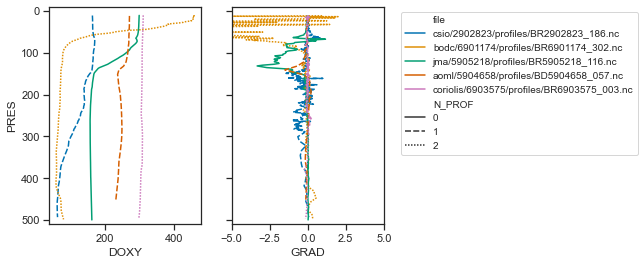

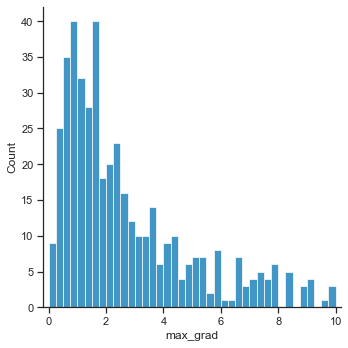

In [10]:
# plot oxygen profiles
fig, axes = plt.subplots(1, 2, sharey=True)
g1 = sns.lineplot(x='DOXY', y='PRES', hue='file', style='N_PROF', data=data.loc[bx.file.iloc[profs]], sort=False, ax=axes[0], legend=False)
# plot gradient profiles
g2 = sns.lineplot(x='GRAD', y='PRES', hue='file', style='N_PROF', data=data.loc[bx.file.iloc[profs]], sort=False, ax=axes[1])
g2.axes.set_ylim((510, -10))
g2.axes.set_xlim((-5, 5))
g2.axes.legend(fontsize=10, loc=1, bbox_to_anchor=(2.7, 1.0))

# next figure - max gradient distributions
# note - this is fundamentally flawed until you carefully remove spikes
g3 = sns.displot(bx.max_grad, bins=np.arange(0, 10.25, 0.25))
g3.ax.set_xlim((-0.2, 10.2))

## 4 - Model sampling/correction

In this section, create an oxygen profile (_a real oceanographic profile, i.e. the "truth"_) where the use can define magnitude, gradient strength and location, and total range. This true profile can then be sampled (_decimated and with time response error as a oxygen optode would_) to simulate our observed oxygen. This will allow us to show the magnitude of the error associated with the time response in a nice, clean environment free of noise or other errors.

In [1]:
# package with optode like sampling and time response correction
from optodetools import sample, correct_response_time

The package `optodetools` contains functions for simulating optode sampling and correcting the response time error, both with and without temperature dependence, following _Bittig et al. 2018_. 

(202.0, -2.0)

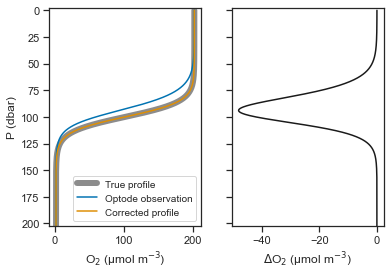

In [3]:
# define a function to create an oxygen profile with arbitrary properties
def oxygen_profile(depth, oxygen_range, central_value, max_grad, depth_grad):

    oxygen = oxygen_range/2*np.tanh((-2*max_grad/oxygen_range)*(depth - depth_grad)) + central_value

    return oxygen

# just as an example, show the truth, sampled, and corrected
depth = np.arange(0, 500, 0.1)[::-1]
oxy_range = 200 # umol kg-1
central = 102 # umol kg-1
max_grad = 7 # umol kg-1 dbar-1
oxycline = 100 # dbar
oxygen = oxygen_profile(depth, oxy_range, central, max_grad, oxycline)

# define a constant temperature
temp = 8*np.ones(depth.size)
speed = 10 # cm s-1
time = -(depth-500)/(speed/100)/60/60/24
observation = sample(time, oxygen, temp, 115)
dmqc_data = correct_response_time(time, observation, temp, 115)

fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].plot(oxygen, depth, linewidth=6, alpha=0.5, color='k', label='True profile')
axes[0].plot(observation, depth, linewidth=1.5, label='Optode observation')
axes[0].plot(dmqc_data, depth, linewidth=1.5, label='Corrected profile')
axes[0].legend(loc=4, fontsize=10)
axes[0].set_ylabel('P (dbar)')
axes[0].set_xlabel('O$_2$ ($\mathregular{\mu}$mol m$^{-3}$)')
axes[1].plot(observation - oxygen, depth, linewidth=1.5, color='k')
axes[1].set_xlabel('$\Delta$O$_2$ ($\mathregular{\mu}$mol m$^{-3}$)')
axes[0].set_ylim((202, -2))

Now, let's loop through a bunch of gradients and see what the resulting max error is:

In [4]:
max_grad = []
max_diff = []
grads = np.arange(0.25, 10.25, 0.25)
for grad in grads:
    oxygen = oxygen_profile(depth, oxy_range, central, grad, oxycline)
    observation = sample(time, oxygen, temp, 115)
    diff = observation - oxygen
    max_grad.append(np.max(np.abs(np.diff(oxygen)/np.diff(depth))))
    max_diff.append(np.max(np.abs(diff)))

Finally, plot those and fit a line (it looks like f(x) = 1 - e^(-x) to me). For now I eyeballed getting the line fit right but I'll do it properly later. 

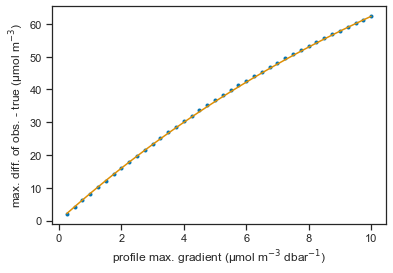

In [16]:
fig, ax = plt.subplots()
ax.plot(max_grad, max_diff, '.')
ax.set_xlabel('profile max. gradient ($\mathregular{\mu}$mol m$^{-3}$ dbar$^{-1}$)')
ax.set_ylabel('max. diff. of obs. - true ($\mathregular{\mu}$mol m$^{-3}$)')
ax.plot(grads, 128*(1-np.exp(-grads/15)))

With the above line, we can translate the histogram from section 3 into an estimated error:

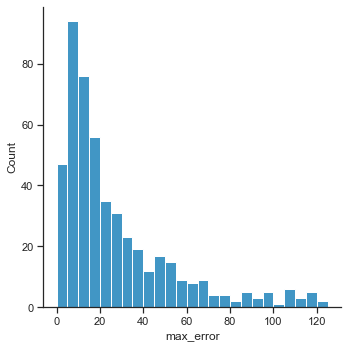

In [25]:
bx['max_error'] = 128*(1 - np.exp(-bx.max_grad/15))
g4 = sns.displot(bx.max_error, bins=np.arange(0, 130, 5))